In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np


data_dir = "./asl_alphabet_train/asl_alphabet_train"
batch_size = 32
num_epochs = 15
num_classes = 29
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ========== Image preprocessing ==========
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.4, hue=0.1),
    transforms.RandomAffine(0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
val_test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [3]:
# =================== Load and partition the dataset ===================
full_ds = datasets.ImageFolder(data_dir, transform=train_transform)
n = len(full_ds)
n_val = int(n * 0.3)
n_test = int(n * 0.3)
n_train = n - n_val - n_test
train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test])
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# =================== Model definition ===================
class LiteCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = LiteCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# ===== Training function =====
def train_model(model, train_loader, val_loader, epochs):
    best_acc = 0.0
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, epochs+1):
        model.train()
        running_loss, running_corrects = 0.0, 0
        for X,y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} Train", leave=False):
            X,y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss= criterion(out,y)
            loss.backward()
            optimizer.step()
            preds = out.argmax(1)
            running_loss     += loss.item()*X.size(0)
            running_corrects += (preds==y).sum().item()

        train_loss = running_loss/len(train_loader.dataset)
        train_acc  = running_corrects/len(train_loader.dataset)

        model.eval()
        vloss, vcorrects = 0.0, 0
        with torch.no_grad():
            for X,y in tqdm(val_loader, desc="Validation", leave=False):
                X,y = X.to(device), y.to(device)
                out = model(X)
                loss= criterion(out,y)
                preds= out.argmax(1)
                vloss     += loss.item()*X.size(0)
                vcorrects += (preds==y).sum().item()

        val_loss = vloss/len(val_loader.dataset)
        val_acc  = vcorrects/len(val_loader.dataset)

        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            os.makedirs("models", exist_ok=True)
            torch.save(model.state_dict(), "models/best_baseline.pth")

    return history

In [6]:
# ===== Drawing functions =====
def plot_history(h):
    epochs = range(1, len(h["train_loss"])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h["train_loss"], label="Train")
    plt.plot(epochs, h["val_loss"],   label="Val")
    plt.title("Loss Curve"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, h["train_acc"],  label="Train")
    plt.plot(epochs, h["val_acc"],    label="Val")
    plt.title("Accuracy Curve"); plt.legend()
    plt.show()

Epoch 1/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 2: Train Loss=2.7452 Train Acc=0.1969 | Val Loss=1.9278 Val Acc=0.4217


Epoch 2/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 3: Train Loss=1.8424 Train Acc=0.4196 | Val Loss=1.2359 Val Acc=0.6569


Epoch 3/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 4: Train Loss=1.3966 Train Acc=0.5441 | Val Loss=0.8995 Val Acc=0.7526


Epoch 4/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 5: Train Loss=1.1251 Train Acc=0.6236 | Val Loss=0.6746 Val Acc=0.8287


Epoch 5/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.9374 Train Acc=0.6830 | Val Loss=0.5432 Val Acc=0.8562


Epoch 6/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.8099 Train Acc=0.7233 | Val Loss=0.4549 Val Acc=0.8734


Epoch 7/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.7088 Train Acc=0.7536 | Val Loss=0.3771 Val Acc=0.9023


Epoch 8/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.6305 Train Acc=0.7784 | Val Loss=0.3150 Val Acc=0.9109


Epoch 9/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.5797 Train Acc=0.7964 | Val Loss=0.2826 Val Acc=0.9248


Epoch 10/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.5205 Train Acc=0.8185 | Val Loss=0.2515 Val Acc=0.9336


Epoch 11/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.4880 Train Acc=0.8247 | Val Loss=0.2165 Val Acc=0.9477


Epoch 12/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.4463 Train Acc=0.8429 | Val Loss=0.1968 Val Acc=0.9530


Epoch 13/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.4037 Train Acc=0.8568 | Val Loss=0.1675 Val Acc=0.9562


Epoch 14/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.3884 Train Acc=0.8605 | Val Loss=0.1679 Val Acc=0.9587


Epoch 15/15 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.3568 Train Acc=0.8719 | Val Loss=0.1442 Val Acc=0.9643


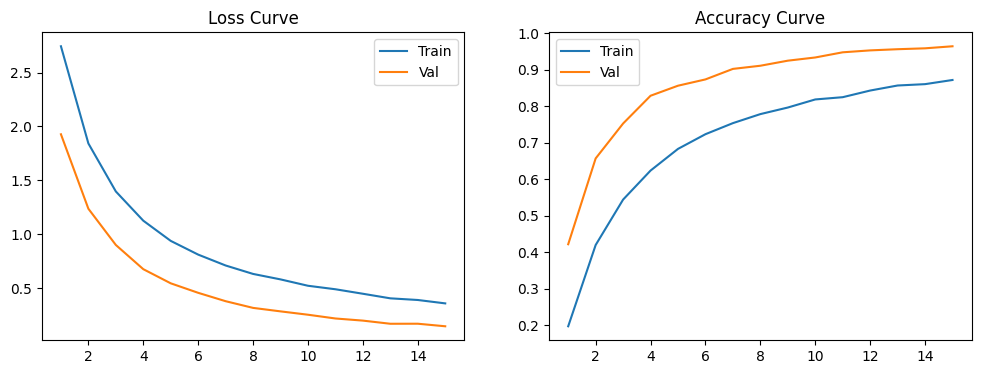

In [50]:
# ========== Train and visualize ==========
history = train_model(model, train_loader, val_loader, num_epochs)
plot_history(history)

In [7]:
# ========== Model Evaluation ==========
model = LiteCNN(num_classes=num_classes)
model.load_state_dict(torch.load("models/best_baseline.pth", map_location=device))
model = model.to(device)
model.eval()

C:\Users\Manson\AppData\Local\Temp\ipykernel_8684\1036611226.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/best_baseline.pth",

LiteCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=256, out_features=29, bias=True)
  )
)

In [8]:
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========== Output evaluation indicators ==========
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
acc = accuracy_score(all_labels, all_preds)

print(f"\nPrecision = {precision:.4f}")
print(f"Recall    = {recall:.4f}")
print(f"F1 Score  = {f1:.4f}")
print(f"Accuracy  = {acc:.2%}")


Precision = 0.9692
Recall    = 0.9685
F1 Score  = 0.9686
Accuracy  = 96.85%


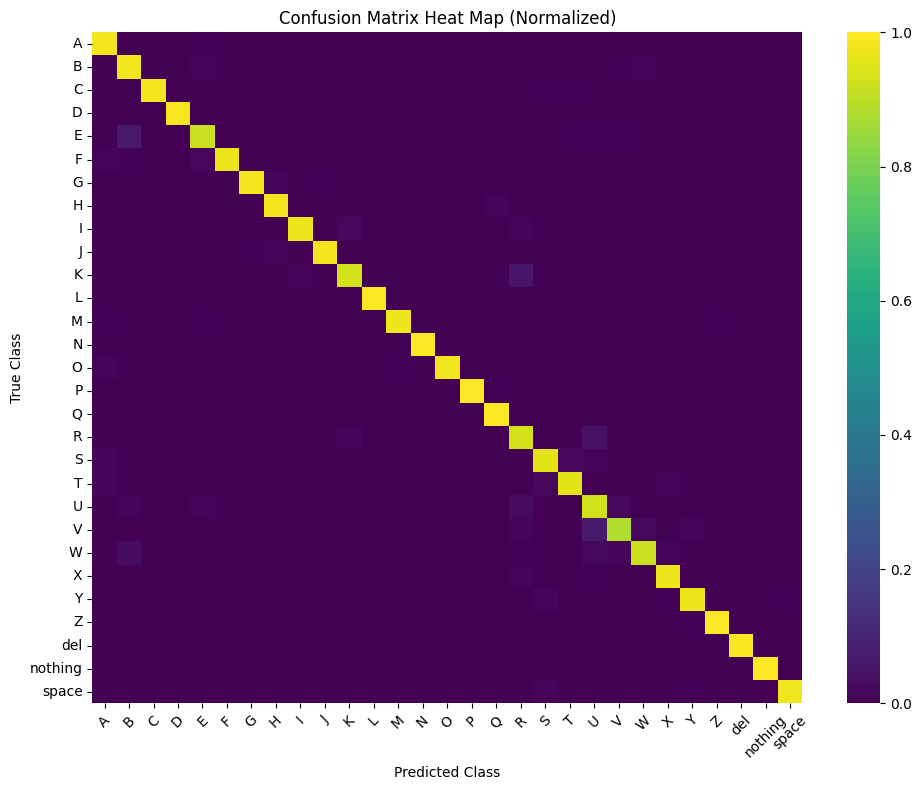

In [12]:
# ======== Confusion Matrix Visualization ========
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, cmap="viridis",
            xticklabels=full_ds.classes,
            yticklabels=full_ds.classes,
            annot=False, fmt=".2f")

plt.title("Confusion Matrix Heat Map (Normalized)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()